In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-type-classification/riceClassification.csv


In [54]:
import torch
import torch.nn as nn ## Neural network
from torch.optim import Adam ## Optimizer
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device ='cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [55]:
import pandas as pd 
import numpy as np
df=pd.read_csv("/kaggle/input/rice-type-classification/riceClassification.csv")

print("Shape is : ",df.shape)
print(df.info())
print(df.describe())

print("Columns are : ",df.columns)
df.head()



Shape is :  (18185, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None
                 id          Area  MajorAxisLength  MinorAxisLength  \
count  18185.000000  18185.000000     18185.000000     18185.000000   
mean    9093.000000   7036

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


***Preprocessing***  

In [56]:
df.dropna(inplace=True)
df.drop(['id'],axis=1,inplace=True)
print(df.shape)

(18185, 11)


In [57]:
print(df['Class'].unique())
print(df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


*Normalize The Data*

In [58]:
original_df=df.copy()

for col in df.columns:
    df[col]=df[col]/df[col].abs().max()

In [59]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [60]:
X=np.array(df.iloc[:,:-1]) # all except last column
Y=np.array(df.iloc[:,-1]) # Only last column

***Splitting into training validation and test data***

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)

X_test,X_val,y_test,y_val=train_test_split(X,Y,test_size=0.5)

In [62]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(X_val.shape,y_val.shape)

(12729, 10) (9092, 10) (12729,) (9092,)
(9093, 10) (9093,)


In [63]:
class dataset(Dataset):
    # already present functions
    def __init__(self,X,Y):
        self.X=torch.tensor(X,dtype=torch.float32).to(device) # convert any datatype to tensors
        self.Y=torch.tensor(Y,dtype=torch.float32).to(device) # convert any datatype to tensors
    # already present functions
    def __len__(self):
        return len(self.X) # return shape of input

    # already present functions
    def __getitem__(self,index): 
        return self.X[index],self.Y[index]        

In [64]:
training_data=dataset(X_train,y_train)
validation_data=dataset(X_val,y_val)
testing_data=dataset(X_test,y_test)

In [65]:
train_data_loader=DataLoader(training_data,batch_size=8,shuffle=True)
test_data_loader=DataLoader(testing_data,batch_size=8,shuffle=True)
validation_data_loader=DataLoader(validation_data,batch_size=8,shuffle=True)


In [66]:
for x,y in train_data_loader:
    print(x) # input
    print("*"*80)
    print(y) # output
    break

tensor([[0.9500, 0.8906, 0.9238, 0.9144, 0.8928, 0.9747, 0.6699, 0.7643, 0.8917,
         0.5470],
        [0.8170, 0.8002, 0.8846, 0.8969, 0.7763, 0.9039, 0.6860, 0.7106, 0.8874,
         0.5132],
        [0.5458, 0.7652, 0.6291, 0.9608, 0.5190, 0.7388, 0.6855, 0.6335, 0.7458,
         0.6900],
        [0.7826, 0.7919, 0.8570, 0.9031, 0.7408, 0.8846, 0.6932, 0.6937, 0.8918,
         0.5242],
        [0.6544, 0.8117, 0.7043, 0.9520, 0.6259, 0.8089, 0.8268, 0.6771, 0.7826,
         0.6538],
        [0.6207, 0.8825, 0.6130, 0.9824, 0.5906, 0.7878, 0.5868, 0.6954, 0.7039,
         0.8168],
        [0.6098, 0.8692, 0.6120, 0.9809, 0.5782, 0.7809, 0.5209, 0.6885, 0.7055,
         0.8057],
        [0.5914, 0.8174, 0.6339, 0.9692, 0.5630, 0.7690, 0.5841, 0.6636, 0.7365,
         0.7316]], device='cuda:0')
********************************************************************************
tensor([0., 0., 1., 0., 1., 1., 1., 1.], device='cuda:0')


In [67]:
HIDDEN_NEURONS=10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__() # same constructor of nn.Model

        self.input_layer=nn.Linear(X.shape[1],HIDDEN_NEURONS)
        self.linear=nn.Linear(HIDDEN_NEURONS,1)
        self.sigmoid=nn.Sigmoid()
        

    def forward(self,x):
        x=self.input_layer(x)
        x=self.linear(x)
        x=self.sigmoid(x)
        return x

model=MyModel().to(device)        

In [68]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [69]:
criterion=nn.BCELoss() # Binary class entropy
optimizer=Adam(model.parameters(),lr=1e-3)

In [70]:
total_loss_train_plot=[]
total_loss_val_plot=[]

total_acc_train_plot=[]
total_acc_val_plot=[]

epochs=15

for epoch in range(epochs):
    total_acc_train=0
    total_acc_val=0
    total_loss_train=0
    total_loss_val=0 

    for data in train_data_loader:
        # print(data)
        inputs,labels=data
        # print(inputs)
        # print(labels)

        prediction=model(inputs).squeeze(1) # squeeze will convert shope from [8,1] -> [8]
        # print(prediction)

        batch_loss=criterion(prediction,labels)

        total_loss_train += batch_loss.item()

        acc=((prediction).round()==labels).sum().item()
        # print(acc)
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step() 
        optimizer.zero_grad() # fro model progress to move it further 

    with torch.no_grad(): 
        for data in validation_data_loader:
            inputs,labels=data
            prediction=model(inputs).squeeze(1)
            batch_loss=criterion(prediction,labels)
            total_loss_val += batch_loss.item()
            acc=((prediction).round()==labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000,4)) #Normalize then round
    total_loss_val_plot.append(round(total_loss_val/1000,4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
    total_acc_val_plot.append(round(total_acc_val/validation_data.__len__()*100,4))

    print(f"Epoch no . {epoch+1} TRAIN LOSS : {round(total_loss_train/1000,4)} TRAIN ACCURACY : {round(total_acc_train/training_data.__len__()*100,4)}")
    print(f"Epoch no . {epoch+1} VALIDATION LOSS : {round(total_loss_val/1000,4)} VALIDATION ACCURACY : {round(total_acc_val/validation_data.__len__()*100,4)}")

    print('\n')
    print('*'*80)

Epoch no . 1 TRAIN LOSS : 0.6123 TRAIN ACCURACY : 92.2461
Epoch no . 1 VALIDATION LOSS : 0.1465 VALIDATION ACCURACY : 98.6363


********************************************************************************
Epoch no . 2 TRAIN LOSS : 0.1309 TRAIN ACCURACY : 98.4602
Epoch no . 2 VALIDATION LOSS : 0.068 VALIDATION ACCURACY : 98.6143


********************************************************************************
Epoch no . 3 TRAIN LOSS : 0.0837 TRAIN ACCURACY : 98.6016
Epoch no . 3 VALIDATION LOSS : 0.055 VALIDATION ACCURACY : 98.5923


********************************************************************************
Epoch no . 4 TRAIN LOSS : 0.0721 TRAIN ACCURACY : 98.5466
Epoch no . 4 VALIDATION LOSS : 0.0463 VALIDATION ACCURACY : 98.7683


********************************************************************************
Epoch no . 5 TRAIN LOSS : 0.0686 TRAIN ACCURACY : 98.6566
Epoch no . 5 VALIDATION LOSS : 0.0454 VALIDATION ACCURACY : 98.6363


**************************************

In [71]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0
    for data in test_data_loader:
        inputs,labels=data
        prediction=model(inputs).squeeze(1)

        batch_loss = criterion(prediction,labels)
        total_loss_test+=batch_loss.item()

        acc=((prediction).round()==labels).sum().item()
        total_acc_test+=acc

    print("Accuracy : ",round(total_acc_test/testing_data.__len__()*100,4))
        

Accuracy :  98.5592


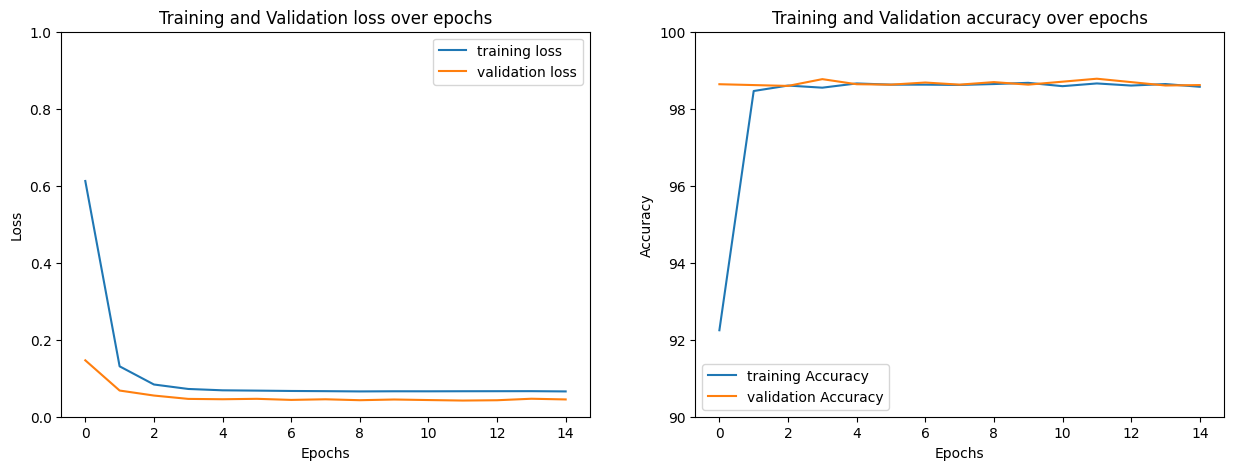

In [76]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label='training loss')
axs[0].plot(total_loss_val_plot,label='validation loss')
axs[0].set_title('Training and Validation loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,1])
axs[0].legend()


axs[1].plot(total_acc_train_plot,label='training Accuracy')
axs[1].plot(total_acc_val_plot,label='validation Accuracy')
axs[1].set_title('Training and Validation accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([90,100])
axs[1].legend()

In [73]:
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [100]:
area=6153/original_df['Area'].abs().max()
MajorAxisLength =80/original_df['MajorAxisLength'].abs().max()
MinorAxisLength=49/original_df['MinorAxisLength'].abs().max()
Eccentricity=30/original_df['Eccentricity'].abs().max()	
ConvexArea=57/original_df['ConvexArea'].abs().max()
EquivDiameter=38/original_df['EquivDiameter'].abs().max()
Extent=98/original_df['Extent'].abs().max()
Perimeter=927/original_df['Perimeter'].abs().max()
Roundness=607/original_df['Roundness'].abs().max()
AspectRation=89/original_df['AspectRation'].abs().max()


pred=model(torch.tensor([area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation],dtype=torch.float32).to(device))

pred.item()

0.0